In [387]:
import flax
from jax import numpy as jnp
import jax
import matplotlib.pyplot as plt
from jax import random
from jax import numpy as jnp
import jax

In [388]:
@jax.jit
def soft_plus(x: float):
    return jnp.log1p(jnp.exp(x))

In [389]:
@jax.jit
def drug_nn(dosage: float, weight: jnp.array, biases: jnp.array) -> float:
    a1 = dosage * weight[0] + biases[0]
    a2 = dosage * weight[1] + biases[1]

    b1 = soft_plus(a1) * weight[2]
    b2 = soft_plus(a2) * weight[3]

    return b1 + b2 + biases[2]


In [390]:
random_state = random.PRNGKey(0)

@jax.jit
def network_forward(dataset_x: jnp.array, weight: jnp.array, biases: jnp.array) -> jnp.array:
    return jax.vmap(lambda x: drug_nn(x, weight, biases))(dataset_x)


@jax.jit
def loss_forward(y_guess: jnp.array, y_ref: jnp.array):
    delta = y_guess - y_ref
    return 0.5 * jnp.mean(delta ** 2)

In [391]:
def test_grad():
    dataset = jnp.array([[0.0, 0.0], [0.5, 1.0], [1.0, 0.0]])
    dataset_x = dataset[:, 0]
    dataset_y = dataset[:, 1]

    weight = jnp.array([
        0.1, # 3.34,
        0.2, # -3.53,
        0.3, # -1.22,
        0.4, # -2.30
    ])

    biases = jnp.array([
        0.0,  #-1.43
        0.0,    #0.57
        0.0     #2.61
    ])

    loss_and_grad = jax.value_and_grad(lambda w, b: loss_forward(
        network_forward(dataset_x, w, b),
        dataset_y
    ), argnums=(0, 1))

    print(loss_forward(network_forward(dataset_x, weight, biases), dataset_y))
    print(loss_and_grad(weight, biases))

test_grad()

0.12778157
(Array(0.12778157, dtype=float32), (Array([0.01601232, 0.02274285, 0.130177  , 0.13568881], dtype=float32), Array([0.02780076, 0.03805577, 0.18035805], dtype=float32)))


In [392]:
def learn(dataset: jnp.ndarray) -> (jnp.array, jnp.array):
    """gradient descent"""
    learning_rate = 0.1
    max_steps = 5000

    weights = random.normal(random_state, (4,))

    biases = jnp.array([
        0.0,  #-1.43
        0.0,    #0.57
        0.0     #2.61
    ])

    dataset_x = dataset[:, 0]
    dataset_y = dataset[:, 1]

    loss_and_grad_fun = jax.jit(jax.value_and_grad(lambda w, b: loss_forward(
        network_forward(dataset_x, w, b),
        dataset_y
    ), argnums=(0, 1)))

    for i in range(max_steps):
        (current_loss, (weight_slopes, bias_slopes)) = loss_and_grad_fun(weights, biases)

        weights = jax.tree_util.tree_map(lambda w, slope: w - learning_rate * slope, weights, weight_slopes)
        biases = jax.tree_util.tree_map(lambda b, slope: b - learning_rate * slope, biases, bias_slopes)

        if i % 100 == 0:
            print(f"epoch: {i}, loss: {current_loss}")

    return weights, biases

(trained_wages, trained_biases) = learn(jnp.array([[0.0, 0.0], [0.5, 1.0], [1.0, 0.0]]))
print(trained_wages, trained_biases)

epoch: 0, loss: 0.16064804792404175
epoch: 100, loss: 0.11191572993993759
epoch: 200, loss: 0.10944131016731262
epoch: 300, loss: 0.10885947942733765
epoch: 400, loss: 0.10831799358129501
epoch: 500, loss: 0.1076778993010521
epoch: 600, loss: 0.10689814388751984
epoch: 700, loss: 0.10593374073505402
epoch: 800, loss: 0.10472653806209564
epoch: 900, loss: 0.10320065915584564
epoch: 1000, loss: 0.10125758498907089
epoch: 1100, loss: 0.09877097606658936
epoch: 1200, loss: 0.09558266401290894
epoch: 1300, loss: 0.09150274842977524
epoch: 1400, loss: 0.08631923794746399
epoch: 1500, loss: 0.07982581853866577
epoch: 1600, loss: 0.07187822461128235
epoch: 1700, loss: 0.062485381960868835
epoch: 1800, loss: 0.05192059278488159
epoch: 1900, loss: 0.0407983660697937
epoch: 2000, loss: 0.030023079365491867
epoch: 2100, loss: 0.020553112030029297
epoch: 2200, loss: 0.01306595653295517
epoch: 2300, loss: 0.00774212833493948
epoch: 2400, loss: 0.0043112291023135185
epoch: 2500, loss: 0.0022803170140

# Flax implementation

In [393]:
from flax import linen as nn
from jax.typing import ArrayLike

class NN(nn.Module):
    @nn.compact
    def __call__(self, x: ArrayLike) -> ArrayLike:
        x = nn.Dense(features=2)(x)
        x = nn.softplus(x)
        return nn.Dense(1)(x)

In [394]:
from flax.training.train_state import TrainState
import optax

learning_rate = 1e-3
model = NN()
variables = model.init(random_state, jnp.ones((1,)))
tx = optax.adam(learning_rate)
max_steps = 10000

learning_state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx,
)

@jax.jit
def network_forward(dataset_x: jnp.array, params) -> jnp.array:
    return jax.vmap(lambda x: learning_state.apply_fn({ 'params': params }, jnp.array([x]))[0])(dataset_x)


def loss_fn(params, x, y):
    prediction = network_forward(x, params)
    loss = optax.squared_error(prediction, y).mean()

    return loss


print(variables)
print(learning_state)

{'params': {'Dense_0': {'kernel': Array([[-1.6581    ,  0.94119257]], dtype=float32), 'bias': Array([0., 0.], dtype=float32)}, 'Dense_1': {'kernel': Array([[ 0.9425951],
       [-0.0566635]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}
TrainState(step=0, apply_fn=<bound method Module.apply of NN()>, params={'Dense_0': {'kernel': Array([[-1.6581    ,  0.94119257]], dtype=float32), 'bias': Array([0., 0.], dtype=float32)}, 'Dense_1': {'kernel': Array([[ 0.9425951],
       [-0.0566635]], dtype=float32), 'bias': Array([0.], dtype=float32)}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7b885d0299e0>, update=<function chain.<locals>.update_fn at 0x7b885d02bba0>), opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu={'Dense_0': {'bias': Array([0., 0.], dtype=float32), 'kernel': Array([[0., 0.]], dtype=float32)}, 'Dense_1': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.]], dtype=float32)}}, nu={'Dense_0': {'bias': Array(

In [395]:
learning_state.params

{'Dense_0': {'kernel': Array([[-1.6581    ,  0.94119257]], dtype=float32),
  'bias': Array([0., 0.], dtype=float32)},
 'Dense_1': {'kernel': Array([[ 0.9425951],
         [-0.0566635]], dtype=float32),
  'bias': Array([0.], dtype=float32)}}

In [396]:
variables['params']

{'Dense_0': {'kernel': Array([[-1.6581    ,  0.94119257]], dtype=float32),
  'bias': Array([0., 0.], dtype=float32)},
 'Dense_1': {'kernel': Array([[ 0.9425951],
         [-0.0566635]], dtype=float32),
  'bias': Array([0.], dtype=float32)}}

In [397]:
def learn_flax(learning_state, dataset: jnp.ndarray):
    dataset_x = dataset[:, 0]
    dataset_y = dataset[:, 1]

    grad_fn = jax.jit(jax.grad(loss_fn))

    for i in range(max_steps):
        grads = grad_fn(learning_state.params, dataset_x, dataset_y)
        learning_state = learning_state.apply_gradients(grads=grads)
        current_loss = loss_fn(learning_state.params, dataset_x, dataset_y)

        if i % 100 == 0:
            print(f"epoch: {i}, loss: {current_loss}")

    return learning_state.params

params = learn_flax(learning_state, jnp.array([[0.0, 0.0], [0.5, 1.0], [1.0, 0.0]]))
params

epoch: 0, loss: 0.29754024744033813
epoch: 100, loss: 0.2709463834762573
epoch: 200, loss: 0.254238486289978
epoch: 300, loss: 0.24458706378936768
epoch: 400, loss: 0.2399846613407135
epoch: 500, loss: 0.23720082640647888
epoch: 600, loss: 0.23492980003356934
epoch: 700, loss: 0.23297858238220215
epoch: 800, loss: 0.23130294680595398
epoch: 900, loss: 0.22986821830272675
epoch: 1000, loss: 0.22864244878292084
epoch: 1100, loss: 0.22759684920310974
epoch: 1200, loss: 0.2267056554555893
epoch: 1300, loss: 0.22594642639160156
epoch: 1400, loss: 0.22529952228069305
epoch: 1500, loss: 0.22474783658981323
epoch: 1600, loss: 0.22427651286125183
epoch: 1700, loss: 0.22387278079986572
epoch: 1800, loss: 0.22352534532546997
epoch: 1900, loss: 0.22322440147399902
epoch: 2000, loss: 0.22296123206615448
epoch: 2100, loss: 0.22272813320159912
epoch: 2200, loss: 0.22251799702644348
epoch: 2300, loss: 0.22232425212860107
epoch: 2400, loss: 0.22214052081108093
epoch: 2500, loss: 0.2219601273536682
epoc

{'Dense_0': {'bias': Array([1.5101978, 4.132737 ], dtype=float32),
  'kernel': Array([[-3.879341 , -2.5272443]], dtype=float32)},
 'Dense_1': {'bias': Array([-3.0940955], dtype=float32),
  'kernel': Array([[-2.7179105],
         [ 1.8658996]], dtype=float32)}}

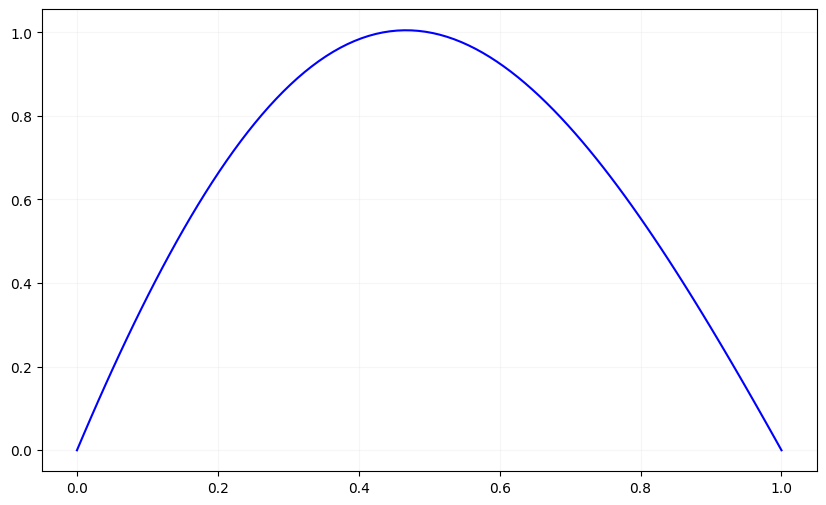

In [404]:
@jax.jit
def nn_apply(dataset_x: jnp.array, params) -> jnp.array:
    return jax.vmap(lambda x: model.apply({ 'params': params }, jnp.array([x]))[0])(dataset_x)

x = jnp.linspace(0, 1, 100)
y = nn_apply(x, params)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="SoftPlus", color="blue")
plt.grid(True, alpha=0.1)
plt.show()